# Displaying RPC graphs

This notebook provides code to display RPC graphs with the various operations extracted by margo's monitoring system.

In [16]:
import cairo
import math
import IPython
from io import BytesIO
from typing import Optional, Mapping


class Colors:
    blue = {'light': (0.8549019607843137, 0.9098039215686274, 0.9882352941176471, 1.0),
            'dark': (0.4235294117647059, 0.5568627450980392, 0.7490196078431373, 1.0)}
    red = {'light': (0.9725490196078431, 0.807843137254902, 0.8, 1.0),
           'dark': (0.40784313725490196, 0.32941176470588235, 0.3137254901960784, 1.0)}
    green = {'light': (0.8352941176470589, 0.9098039215686274, 0.8313725490196079, 1.0),
             'dark': (0.5098039215686274, 0.7019607843137254, 0.4, 1.0)}
    yellow = {'light': (1.0, 0.9490196078431372, 0.8, 1.0),
              'dark': (0.8392156862745098, 0.7137254901960784, 0.33725490196078434, 1.0)}
    purple = {'light': (0.8823529411764706, 0.8352941176470589, 0.9058823529411765, 1.0),
              'dark': (0.5882352941176471, 0.45098039215686275, 0.6509803921568628, 1.0)}
    grey = {'light': (0.9, 0.9, 0.9, 1.0),
            'dark': (0.5, 0.5, 0.5, 1.0)}
    
class RPCGraph:
    
    def draw_arrow(self, context: cairo.Context, x: float):
        arrow_length = 0.98
        arrow_angle = math.pi/2
        arrowhead_angle = math.pi/6
        arrowhead_length = 0.04
        context.move_to(x, 0)
        context.rel_line_to(arrow_length * math.cos(arrow_angle), arrow_length * math.sin(arrow_angle))
        context.rel_move_to(-arrowhead_length * math.cos(arrow_angle - arrowhead_angle), -arrowhead_length * math.sin(arrow_angle - arrowhead_angle))
        context.rel_line_to(arrowhead_length * math.cos(arrow_angle - arrowhead_angle), arrowhead_length * math.sin(arrow_angle - arrowhead_angle))
        context.rel_line_to(-arrowhead_length * math.cos(arrow_angle + arrowhead_angle), -arrowhead_length * math.sin(arrow_angle + arrowhead_angle))
        context.set_source_rgb(0,0,0)
        context.set_line_width(0.015)
        context.stroke()
    
    def draw_block(self,
                   context: cairo.Context,
                   x: float, y: float, width: float, height: float,
                   fill_color: tuple[float, float, float, float],
                   border_color: Optional[tuple[float, float, float, float]] = None):
        if border_color is None:
            border_color = fill_color
        context.set_line_width(0.002)
        context.set_source_rgba(*fill_color)
        context.rectangle(x, y, width, height)
        context.fill()
        context.stroke()
        context.set_source_rgba(*border_color)  
        context.rectangle(x, y, width, height)
        context.stroke()
          
    def draw(self):
        return IPython.display.SVG(data=self.svgio.getvalue())

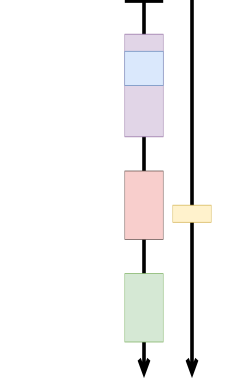

In [17]:
class OriginRPCGraph(RPCGraph):
    
    def __init__(self, iforward: Mapping[str,float],
                 set_input: Mapping[str, float],
                 wait: Mapping[str, float],
                 forward_cb: Mapping[str, float],
                 get_output: Optional[Mapping[str, float]] = None):
        self.svgio = BytesIO()
        with cairo.SVGSurface(self.svgio, 240, 380) as surface:
            context = cairo.Context(surface)
            context.scale(240, 380)
            # vertical arrows
            self.draw_arrow(context, 0.6)
            self.draw_arrow(context, 0.8)
            # create line
            context.move_to(0.52, 0)
            context.rel_line_to(0.16, 0)
            context.set_source_rgb(0,0,0)
            context.set_line_width(0.015)
            context.stroke()
            # iforward, set_input, wait, get_output blocks
            for block, color in zip(
                [iforward, set_input, wait, get_output],
                [Colors.purple,  Colors.blue,  Colors.red,  Colors.green]):
                if block is None: continue
                self.draw_block(context, 0.52, block['start']*0.9, 0.16, block['duration']*0.9, color['light'], color['dark'])
            # forward_cb block
            self.draw_block(context, 0.72, forward_cb['start']*0.9, 0.16, forward_cb['duration']*0.9, Colors.yellow['light'], Colors.yellow['dark'])
        
    
OriginRPCGraph(
    iforward={'start': 0.1, 'duration': 0.3},
    set_input={'start': 0.15, 'duration': 0.1},
    wait={'start': 0.5, 'duration': 0.2},
    forward_cb={'start': 0.6, 'duration': 0.05},
    get_output={'start': 0.8, 'duration': 0.2}).draw()

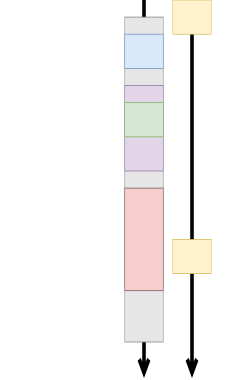

In [29]:
class TargetRPCGraph(RPCGraph):
    
    def __init__(self, handler: Mapping[str,float],
                 ult: Mapping[str, float],
                 get_input: Optional[Mapping[str, float]] = None,
                 irespond: Optional[Mapping[str, float]] = None,
                 set_output: Optional[Mapping[str, float]] = None,
                 wait: Optional[Mapping[str, float]] = None,
                 respond_cb: Optional[Mapping[str, float]] = None):
        self.svgio = BytesIO()
        with cairo.SVGSurface(self.svgio, 240, 380) as surface:
            context = cairo.Context(surface)
            context.scale(240, 380)
            # vertical arrows
            self.draw_arrow(context, 0.6)
            self.draw_arrow(context, 0.8)
            # iforward, set_input, wait, get_output blocks
            for block, color in zip(
                [ult, get_input, irespond, set_output, wait],
                [Colors.grey,  Colors.blue,  Colors.purple,  Colors.green, Colors.red]):
                if block is None: continue
                self.draw_block(context, 0.52, block['start']*0.9, 0.16, block['duration']*0.9, color['light'], color['dark'])
            # handler block
            self.draw_block(context, 0.72, handler['start']*0.9, 0.16, handler['duration']*0.9, Colors.yellow['light'], Colors.yellow['dark'])
            # respond_cb block
            if respond_cb is not None:
                self.draw_block(context, 0.72, respond_cb['start']*0.9, 0.16, respond_cb['duration']*0.9, Colors.yellow['light'], Colors.yellow['dark'])
        
    
TargetRPCGraph(
    handler={'start': 0.0, 'duration': 0.1},
    ult={'start': 0.05, 'duration': 0.95},
    get_input={'start': 0.1, 'duration': 0.1},
    irespond={'start': 0.25, 'duration': 0.25},
    set_output={'start': 0.3, 'duration': 0.1},
    wait={'start': 0.55, 'duration': 0.3},
    respond_cb={'start': 0.7, 'duration': 0.1}).draw()